# Lab | Making predictions with logistic regression
In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

## Instructions
1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
2. Read the data into a Pandas dataframe.
3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

### Import libraries

In [235]:
from sqlalchemy import create_engine
import getpass  # To get the password without showing the input
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [236]:

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dfply import *
import seaborn as sns
sns.set_theme(style="whitegrid")
import datetime as dt

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #for classification!!!
from sklearn.metrics import accuracy_score

%matplotlib inline


### Gather data

In [237]:
# query to get some film and rental information from the tables rental, inventory and film
query = '''SELECT 
	f.film_id, 
	f.title, 
    EXTRACT(YEAR FROM r.rental_date) AS rental_year,
    EXTRACT(MONTH FROM r.rental_date) AS rental_month,
    EXTRACT(DAY FROM r.rental_date) AS rental_day,
    f.rating, 
    c.name AS category, 
    COUNT(rental_id) OVER (PARTITION BY film_id) AS total_rental_counts
FROM rental r
JOIN inventory i
USING(inventory_id)
JOIN film f
USING(film_id)
JOIN film_category fc
USING(film_id)
JOIN category c
USING(category_id)
HAVING rental_year < 2007;'''
df = pd.read_sql_query(query, engine)
df.head()

,film_id,title,rental_year,rental_month,rental_day,rating,category,total_rental_counts
0,1,ACADEMY DINOSAUR,2005,8,18,PG,Documentary,23
1,1,ACADEMY DINOSAUR,2005,8,21,PG,Documentary,23
2,1,ACADEMY DINOSAUR,2005,8,21,PG,Documentary,23
3,1,ACADEMY DINOSAUR,2005,8,21,PG,Documentary,23
4,1,ACADEMY DINOSAUR,2005,8,22,PG,Documentary,23


### Data Cleaning and Exploration

In [238]:
# transform text values to lowercase
def lowercase(x):
    x = x.apply(str.lower)
    return x
df['title'] = lowercase(df['title'])

In [239]:
df.head()

,film_id,title,rental_year,rental_month,rental_day,rating,category,total_rental_counts
0,1,academy dinosaur,2005,8,18,PG,Documentary,23
1,1,academy dinosaur,2005,8,21,PG,Documentary,23
2,1,academy dinosaur,2005,8,21,PG,Documentary,23
3,1,academy dinosaur,2005,8,21,PG,Documentary,23
4,1,academy dinosaur,2005,8,22,PG,Documentary,23


In [240]:
df.shape

(16044, 8)

In [241]:
df.info() # no null values, dtypes seem to be correct as well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   film_id              16044 non-null  int64 
 1   title                16044 non-null  object
 2   rental_year          16044 non-null  int64 
 3   rental_month         16044 non-null  int64 
 4   rental_day           16044 non-null  int64 
 5   rating               16044 non-null  object
 6   category             16044 non-null  object
 7   total_rental_counts  16044 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1002.9+ KB


In [242]:
df.total_rental_counts.nunique()

31

In [243]:
df.total_rental_counts.unique()

array([23,  7, 12, 21, 15, 18, 24, 26,  9, 22, 14, 10, 13, 31,  6, 16, 11,
        8, 19, 25, 17, 29, 27,  5, 20, 34, 30, 28, 32,  4, 33])

There are a total of 16044 rentals. After looking at the different values in the total_rental_counts column which has been created to get the total number of times a film has been rented in the past, I will be applying some feature engineering later on regarding the popularity of each film.

To do so, I made a new query taking only the distict films together with a new column which shows if this particular film has been rented in February 2006 (rented_feb06). This will also be the target in the classification model.

In [244]:
# list of distinct films
query_film_list = '''SELECT DISTINCT s.film_id, title, film_duration, rating, category, total_rental_counts, feb.film_id as rented_feb06
FROM selection s
LEFT JOIN (SELECT film_id FROM selection WHERE rental_year = 2006 AND rental_month = 2) feb
USING(film_id);'''
film_list = pd.read_sql_query(query_film_list, engine)
film_list.head()

,film_id,title,film_duration,rating,category,total_rental_counts,rented_feb06
0,1,ACADEMY DINOSAUR,86,PG,Documentary,23,NaN
1,2,ACE GOLDFINGER,48,G,Horror,7,2.0
2,3,ADAPTATION HOLES,50,NC-17,Documentary,12,NaN
3,4,AFFAIR PREJUDICE,117,G,Horror,23,4.0
4,5,AFRICAN EGG,130,G,Family,12,5.0


In [245]:
film_list['title'] = lowercase(film_list['title'])

In [246]:
film_list['rented_feb06'].head()

0    NaN
1    2.0
2    NaN
3    4.0
4    5.0
Name: rented_feb06, dtype: float64

Looking at the target rented_feb06, I will be cleaning the values so that the column becomes a boolean:  1 for films which were rented in Feb 2006 and 0 otherwise.

In [247]:
film_list['rented_feb06'] = film_list['rented_feb06'].fillna(0) #replace Nan with 0

In [248]:
#replace film ids with 1. FYI, this column was taken with a left self join from the original query to include only film_ids of films rented in Feb 2006
film_list['rented_feb06'] = film_list['rented_feb06'].apply(lambda x : 1 if x!= 0 else x).astype(int) 

In [249]:
film_list['rented_feb06'].value_counts()

0    790
1    168
Name: rented_feb06, dtype: int64

Just looking at the value counts above, we can see that there is an imbalance in the number of films rented in Feb as opposed to those that weren't. This will definitely affect the classification model's performance.

### Feature Engineering
Adding new popularity column which will be based on the number of times a film has been rented: 
- unpopular (1 - 5)
- mildly unpopular (6 - 9)
- mildly popular (10 - 14)
- popular (15 - 19)
- very popular (20 and up)

Keep in mind although the numbers seem to be quite low, the maximum number of times a film has been rented in sakila is only 31 times.

In [250]:
# conditions to append to the new popularity column
condition = [(film_list['total_rental_counts'] == 0),
             (film_list['total_rental_counts'].between(1,5)),
             (film_list['total_rental_counts'].between(6,10)),
             (film_list['total_rental_counts'].between(11,15)),
             (film_list['total_rental_counts'].between(16,20)),
             (film_list['total_rental_counts'] >= 21)]
choice = ['never_rented', 'unpopular', 'mildly_unpopular', 'mildly_popular', 'popular', 'very_popular']
film_list['popularity'] = np.select(condition, choice)

In [251]:
film_list.sample(15) #to check the results of the new column added

,film_id,title,film_duration,rating,category,total_rental_counts,rented_feb06,popularity
371,393,halloween nuts,47,PG-13,Documentary,10,0,mildly_unpopular
852,890,tights dawn,172,R,Sports,26,0,very_popular
256,273,effect gladiator,107,PG,Family,25,1,very_popular
381,403,harry idaho,121,PG-13,Drama,30,1,very_popular
49,55,barbarella streetcar,65,G,Sci-Fi,25,0,very_popular
701,734,road roxanne,158,R,Documentary,19,0,popular
820,856,streetcar intentions,73,R,Horror,25,0,very_popular
144,155,cleopatra devil,150,PG-13,New,18,1,popular
179,191,crooked frogmen,143,PG-13,Children,23,1,very_popular
419,443,hurricane affair,49,PG,Comedy,24,0,very_popular


In [252]:
film_list.duplicated().any() # no duplicates

False

In [253]:
film_list.describe(include='all') # to check which ratings, category and popularity have the most number of occurence.

,film_id,title,film_duration,rating,category,total_rental_counts,rented_feb06,popularity
count,958.000000,958,958.000000,958,958,958.000000,958.000000,958
unique,NaN,958,NaN,5,16,NaN,NaN,5
top,NaN,academy dinosaur,NaN,PG-13,Sports,NaN,NaN,very_popular
freq,NaN,1,NaN,213,73,NaN,NaN,295
mean,502.598121,NaN,115.490605,NaN,NaN,16.747390,0.175365,NaN
std,287.541738,NaN,40.471844,NaN,NaN,6.676185,0.380478,NaN
min,1.000000,NaN,46.000000,NaN,NaN,4.000000,0.000000,NaN
25%,256.250000,NaN,80.250000,NaN,NaN,11.000000,0.000000,NaN
50%,504.500000,NaN,114.000000,NaN,NaN,16.000000,0.000000,NaN
75%,751.750000,NaN,150.000000,NaN,NaN,22.000000,0.000000,NaN


### Numerical Variables

In [254]:
numerical = film_list[['film_duration', 'total_rental_counts', 'rented_feb06']]
numerical.head()

,film_duration,total_rental_counts,rented_feb06
0,86,23,0
1,48,7,1
2,50,12,0
3,117,23,1
4,130,12,1


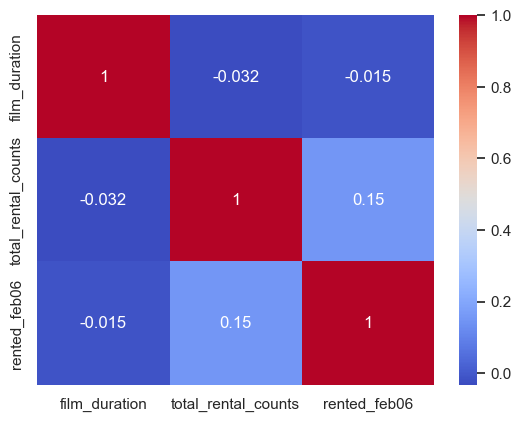

In [255]:
corr_matrix=numerical.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Correlation shows very little relationship between the variables. However, just looking at the positive or negative relationship, we can see that film_duration has a negative relationship on whether a film is rented.

/Users/rachelleflores/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_rental_counts', ylabel='Density'>

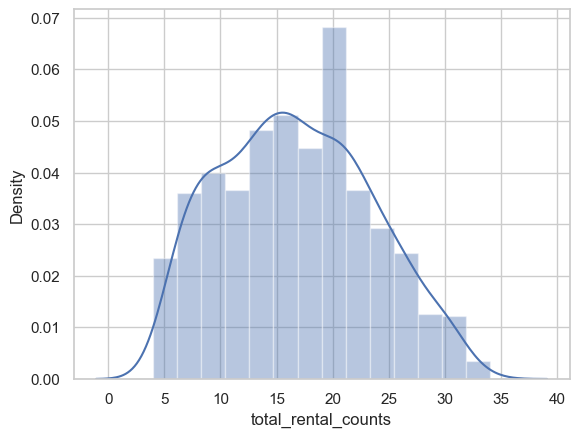

In [256]:
sns.distplot(numerical.total_rental_counts)

/Users/rachelleflores/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='film_duration', ylabel='Density'>

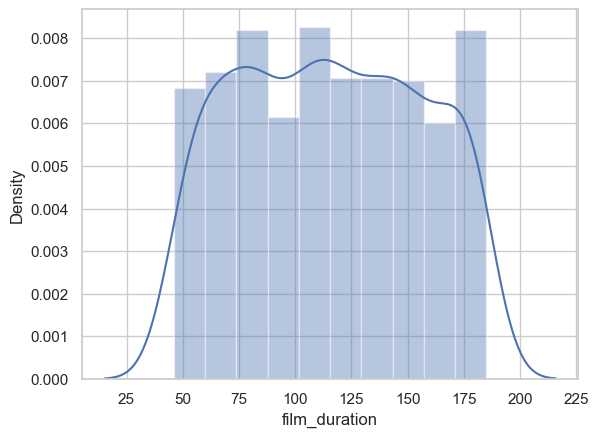

In [257]:
sns.distplot(numerical.film_duration)

/Users/rachelleflores/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rented_feb06', ylabel='Density'>

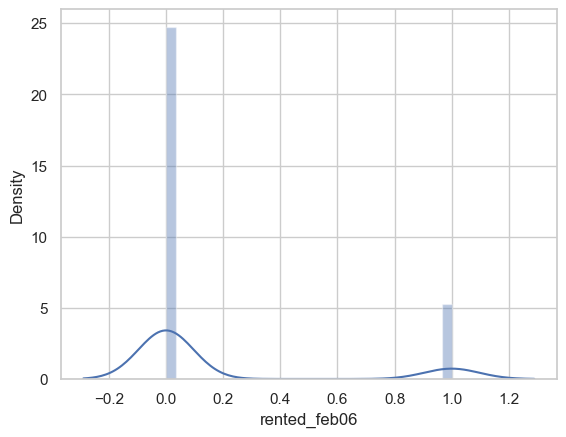

In [258]:
sns.distplot(numerical.rented_feb06)

In [259]:
X_num= numerical.drop(columns='rented_feb06')
X_num.head()

,film_duration,total_rental_counts
0,86,23
1,48,7
2,50,12
3,117,23
4,130,12


In [260]:
transformer = StandardScaler().fit(X_num)
x_stand = transformer.transform(X_num)
x_num = pd.DataFrame(x_stand)
x_num.columns = X_num.columns
x_num.head()

,film_duration,total_rental_counts
0,-0.729050,0.937044
1,-1.668465,-1.460787
2,-1.619022,-0.711465
3,0.037314,0.937044
4,0.358693,-0.711465


### Categorical Variables

In [263]:
categorical = film_list[['rating','category','rented_feb06','popularity']]
categorical.head()

,rating,category,rented_feb06,popularity
0,PG,Documentary,0,very_popular
1,G,Horror,1,mildly_unpopular
2,NC-17,Documentary,0,mildly_popular
3,G,Horror,1,very_popular
4,G,Family,1,mildly_popular


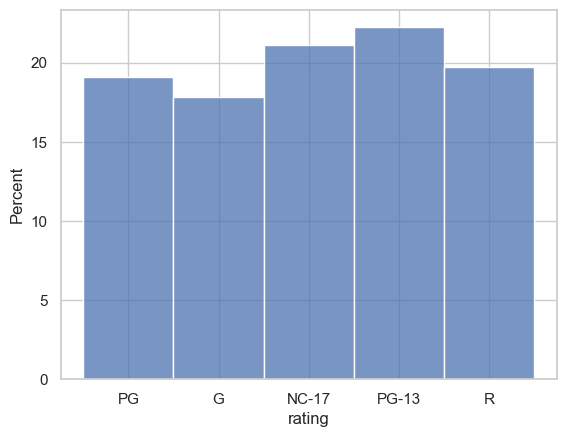

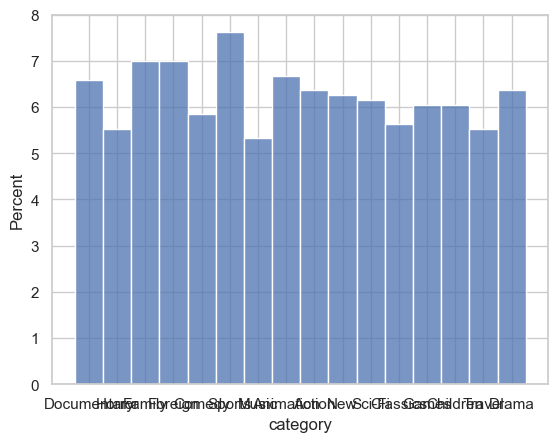

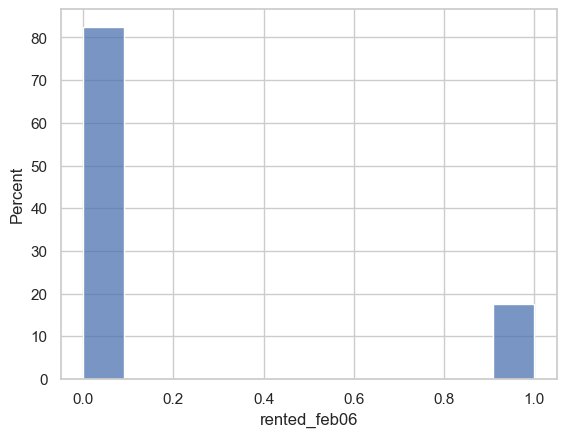

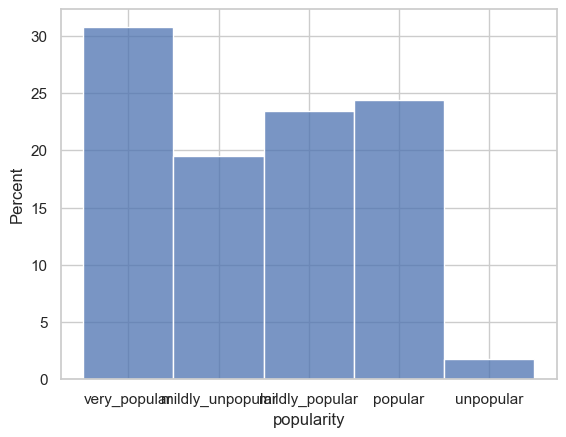

In [264]:
for col in categorical.columns:
    sns.histplot(categorical[col], stat='percent')
    plt.show()

In [265]:
y = categorical['rented_feb06']
categorical.drop('rented_feb06', axis = 1, inplace=True)

/var/folders/8z/6dxd_gws0p1gkky66vd1t2xh0000gn/T/ipykernel_54430/1016461716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical.drop('rented_feb06', axis = 1, inplace=True)


In [266]:
y.head()  # Target appart

0    0
1    1
2    0
3    1
4    1
Name: rented_feb06, dtype: int64

In [267]:
cat = pd.get_dummies(categorical, columns=['rating', 'category','popularity'])
cat.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,...,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,popularity_mildly_popular,popularity_mildly_unpopular,popularity_popular,popularity_unpopular,popularity_very_popular
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [268]:
X = pd.concat([x_num, cat], axis=1) # Numerical and dummies from categoricals
X.head()

,film_duration,total_rental_counts,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Action,category_Animation,category_Children,...,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,popularity_mildly_popular,popularity_mildly_unpopular,popularity_popular,popularity_unpopular,popularity_very_popular
0,-0.729050,0.937044,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-1.668465,-1.460787,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.619022,-0.711465,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.037314,0.937044,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.358693,-0.711465,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [269]:
# We separate training and testing datasets and correspondant targets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [270]:
len(X_train), len(y_train)

(670, 670)

In [271]:
# We train the training dataset using Logistic Regression (multiclass classification)
classification = LogisticRegression(random_state=1, multi_class='ovr').fit(X_train, y_train)

In [272]:
# We predict on the testing dataset
predictions = classification.predict(X_test)

In [273]:
pred = pd.Series(predictions)
pred.value_counts()

0    288
dtype: int64

In [274]:
y_test.value_counts()

0    234
1     54
Name: rented_feb06, dtype: int64

In [275]:
cm = confusion_matrix(y_test, pred)
cm

array([[234,   0],
       [ 54,   0]])

The accuracy of the model on test set is: 0.81 


/Users/rachelleflores/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


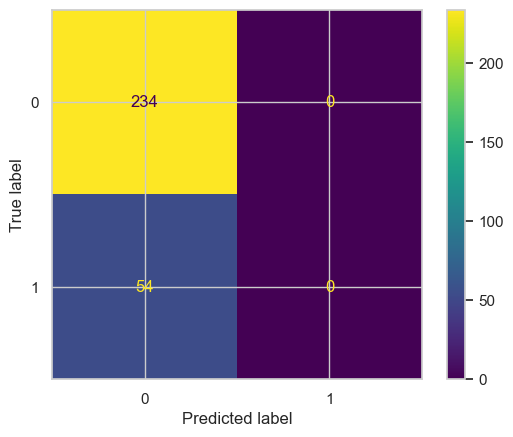

The Kappa of your model is: 0.00


In [277]:
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP
print("The Kappa of your model is: %4.2f" % (cohen_kappa_score(y_test, predictions)))

We can see that the model is very good at predicting the 0 values(not rented in Feb 2006) but very bad at predicting the 1 values. The kappa score of 0 also indicates that the model model is no better than random guessing. Therefore, it definitely needs to be reworked and perhaps add other features which could better explain the target.